In [0]:
# import library packages
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [0]:
# download dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True)

# load dataset into DataLoader with defined batch size
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=0)

In [0]:
# choose device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

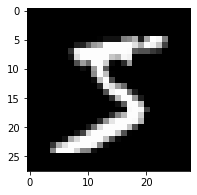

In [0]:
# show a sample image
dataiter = iter(train_loader)
img, label = dataiter.next()
img = img.numpy()

img = np.squeeze(img[0])
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
plt.show()

**Discriminator**

In [0]:
class Discriminator(nn.Module):
  """ This is the Disciminator, part of GAN """

  def __init__(self):
    """ Initialization the structure of Discriminator network
    """
    super(Discriminator, self).__init__()

    self.fc1 = nn.Linear(784,128)
    self.fc2 = nn.Linear(128,64)
    self.fc3 = nn.Linear(64,32)
    self.fc4 = nn.Linear(32,1)
    self.dropout = nn.Dropout(0.3)
  
  def forward(self, x):
    """ forward pass

    Parameters:
    ----------
    x: Tensor
          samples (in batch) from MNIST dataset

    Return:
    ----------
    out: Tensor
          the output of discriminator that predict
          the input image is real or fake   
          
    """
    # flatten image
    x = x.view(-1, 28*28)
    
    # hidden layers
    x = F.leaky_relu(self.fc1(x), negative_slope=0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    out = self.fc4(x)

    return out


In [0]:
class Generator(nn.Module):
  """ This is the Generator, part of GAN """

  def __init__(self):
    """ Initialization the structure of Generator network
    """
    super(Generator, self).__init__()

    self.fc1 = nn.Linear(100, 32)
    self.fc2 = nn.Linear(32, 64)
    self.fc3 = nn.Linear(64, 128)
    self.fc4 = nn.Linear(128, 784)
    self.dropout = nn.Dropout(0.3)
  
  def forward(self, x):
    """ forward pass

    Parameters:
    ----------
    x: Tensor
          random samples from Uniform distribution

    Return:
    ----------
    out: Tensor
          the fake image generated from the Genertor network  
          
    """

    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    out = torch.tanh(self.fc4(x))
    
    return out

In [0]:
# define loss functions
def real_loss(D_out, smooth=False):
    """ loss function for model classify real image

    Parameters:
    ----------
    D_out: Tensor
          real images

    Return:
    ----------
    loss: Tensor
          loss value 
          
    """
  batch_size = D_out.size(0)
  if smooth:
    labels = 0.9*torch.ones(batch_size).to(device)
  else:
    labels = torch.ones(batch_size).to(device)
  
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)

  return loss

def fake_loss(D_out):
    """ loss function for model classify fake image

    Parameters:
    ----------
    D_out: Tensor
          fake images

    Return:
    ----------
    out: Tensor
          loss value
          
    """
  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size).to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)

  return loss

In [0]:
# Models
D_model = Discriminator().to(device)
G_model = Generator().to(device)

# Optimizers
lr = 2e-3
D_optimizer = optim.Adam(D_model.parameters(), lr=lr)
G_optimizer = optim.Adam(G_model.parameters(), lr=lr)

In [0]:
n_epoch = 20
samples = []
losses = []

fixed_z = np.random.uniform(-1,1,(16,100))
fixed_z = torch.from_numpy(fixed_z).float().to(device)

for i in range(n_epoch):
  for batch_idx, (imgs, _) in enumerate(train_loader):

    imgs = imgs.to(device)
    batch_size = imgs.size(0)

    D_model.train()
    G_model.train()

    # Train Discriminator
    D_optimizer.zero_grad()
    # real images
    imgs = imgs*2 - 1 
    real_pred = D_model(imgs)
    r_loss = real_loss(real_pred, smooth=True)

    # generate random samples
    z = np.random.uniform(low=-1, high=1, size=(batch_size, 100))
    z = torch.from_numpy(z).float().to(device)

    # classify real and fake images
    fake_imgs = G_model(z)
    fake_pred = D_model(fake_imgs)
    f_loss = fake_loss(fake_pred)

    # loss function for Discriminator
    D_loss = r_loss + f_loss
    D_loss.backward()
    D_optimizer.step()

    # Train Generator
    G_optimizer.zero_grad()
    z = np.random.uniform(low=-1, high=1, size=(batch_size, 100))
    z = torch.from_numpy(z).float().to(device)

    # # classify fake images
    fake_imgs = G_model(z)
    fake_pred = D_model(fake_imgs)

    # loss function for Generator
    G_loss = real_loss(fake_pred)
    G_loss.backward()
    G_optimizer.step()
    

    if ((batch_idx % 400) == 0):
      print("Epoch [{:3d}/{:3d}] | Dloss: {:3.5f} | Gloss: {:3.5f}".format(i+1, n_epoch, D_loss.item(), G_loss.item()))
  
  losses.append((D_loss.item(), G_loss.item()))

  # generate samples
  G_model.eval()
  imgs = G_model(z)
  samples.append(imgs)

Epoch [  1/ 20] | Dloss: 1.01323 | Gloss: 0.76372
Epoch [  1/ 20] | Dloss: 1.55562 | Gloss: 0.78695
Epoch [  1/ 20] | Dloss: 1.27965 | Gloss: 2.59379
Epoch [  2/ 20] | Dloss: 1.14693 | Gloss: 1.16623
Epoch [  2/ 20] | Dloss: 1.36022 | Gloss: 0.65927
Epoch [  2/ 20] | Dloss: 1.26917 | Gloss: 0.98764
Epoch [  3/ 20] | Dloss: 1.25964 | Gloss: 1.36903
Epoch [  3/ 20] | Dloss: 1.21736 | Gloss: 1.84960
Epoch [  3/ 20] | Dloss: 1.38568 | Gloss: 0.95420
Epoch [  4/ 20] | Dloss: 1.22068 | Gloss: 1.55963
Epoch [  4/ 20] | Dloss: 1.09068 | Gloss: 1.29322
Epoch [  4/ 20] | Dloss: 1.06479 | Gloss: 1.49804
Epoch [  5/ 20] | Dloss: 1.14716 | Gloss: 1.34062
Epoch [  5/ 20] | Dloss: 1.22475 | Gloss: 2.31424
Epoch [  5/ 20] | Dloss: 0.99995 | Gloss: 1.50620
Epoch [  6/ 20] | Dloss: 1.01608 | Gloss: 3.91490
Epoch [  6/ 20] | Dloss: 1.06763 | Gloss: 1.45597
Epoch [  6/ 20] | Dloss: 1.16211 | Gloss: 1.66140
Epoch [  7/ 20] | Dloss: 1.10210 | Gloss: 1.30655
Epoch [  7/ 20] | Dloss: 1.12862 | Gloss: 1.46637


In [0]:
import pickle as pkl
# Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

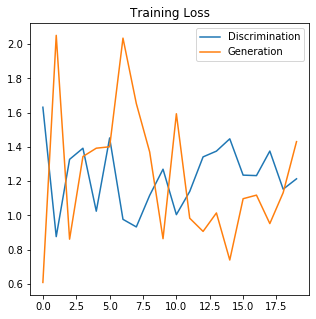

In [0]:
# the training loss curve
fig = plt.figure(figsize=(5,5))
losses = np.array(losses)
plt.plot(losses.T[0], label='Discrimination')
plt.plot(losses.T[1], label='Generation')
plt.title('Training Loss')
plt.legend()
plt.show()

In [0]:
def view_samples(epoch, samples):
  fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(7,7), sharex=True, sharey=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = torch.Tensor.cpu(img.detach()).numpy()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
with open('train_samples.pkl', 'rb') as f:
  samples = pkl.load(f)

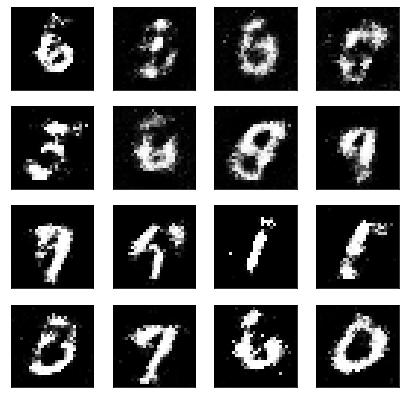

In [0]:
view_samples(-1, samples)

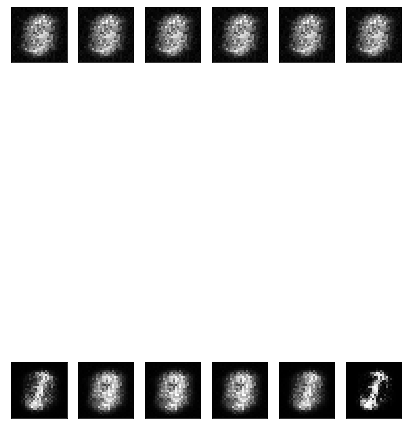

In [0]:
fig, axes = plt.subplots(nrows=2, ncols=6, sharex=True, sharey=True, figsize=(7,12))

for sample, axes_row in zip(samples[::int(len(samples)/10)], axes):
  for img, ax in zip(sample[::int(len(sample)/6)], axes_row):
    img = torch.Tensor.cpu(img.detach()).numpy()
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap = 'Greys_r')

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


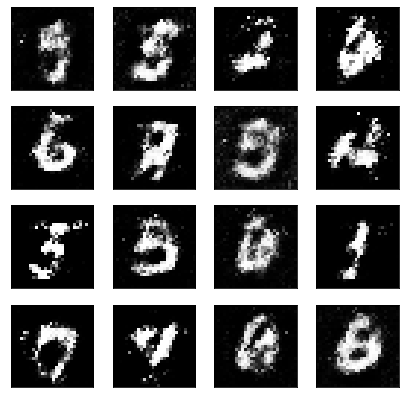

In [0]:
z = np.random.uniform(-1, 1, (16,100))
z = torch.from_numpy(z).float().to(device)

G_model.eval()
img = G_model(z)
view_samples(0, [img])